In [22]:
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
import json
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START

In [23]:

# Initialize model
model = ChatOpenAI(model="gpt-4", temperature=0.7)

In [24]:
import os
import json
import requests
import openai

# Load API keys
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
EXCHANGERATE_API_KEY = os.getenv("EXCHANGERATE_API_KEY")

from langchain_community.tools.tavily_search import TavilySearchResults

search=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

# User input prompt
user_prompt = "I’m planning to visit Bangalore for 1 week. Can you create an itinerary?"

In [25]:
EXCHANGERATE_API_KEY

'bd89577065e7c9fadf9b8690ed36cbc0'

In [26]:
from typing import List,Dict, TypedDict
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator

# class TravelState(TypedDict):
#     questions: Annotated[Sequence[BaseMessage], operator.add]
#     city: str
#     days: int
#     from_currency: str
#     to_currency: str
#     attractions: str
#     restaurants: str
#     activities: str
#     transportation: str
#     current_weather_report: str
#     weather_forecast_report: str
#     locations_to_visit: list
#     attractions_coordinates: list
#     central_point: tuple
#     hotels_at_location_info: dict
#     hotel_per_night: int
#     food_per_day: int
#     transport_per_day: int
#     attraction_per_day: float
#     daily_budget: float
#     total_budget: float
#     exchange_rate: float
#     converted_amount: float
#     itinerary: dict
class TravelState(TypedDict):
    questions: Annotated[Sequence[BaseMessage], operator.add] #Annotated[str, "single_write"]#Annotated[Sequence[BaseMessage], operator.add]
    city: Annotated[str, "single_write"]     # ✅ FIXED LINE
    days: Annotated[int, "single_write"]
    from_currency: str
    to_currency: str
    attractions: str
    restaurants: str
    activities: str
    transportation: str
    current_weather_report: str
    weather_forecast_report: str
    locations_to_visit: list
    attractions_coordinates: list
    central_point: tuple
    hotels_at_location_info: dict
    hotel_per_night: int
    food_per_day: int
    transport_per_day: int
    attraction_per_day: float
    daily_budget: float
    total_budget: float
    exchange_rate: float
    converted_amount: float
    itinerary: Annotated[dict, "single_write"]



In [27]:
def extract_location_and_days_gpt(state: TravelState) -> TravelState:
    prompt = state.get("questions")[-1]

    # Step 1: Extract city, days, from_currency, to_currency (if mentioned)
    system_msg = SystemMessage(
        content="""
You are a travel planning assistant.
Extract the following from the user's message:
1. city they want to visit
2. number of days (integer only, no assumptions)
3. from_currency (if mentioned by user)
4. to_currency (currency used in the destination country)

Respond ONLY in JSON format like:
{
  "city": "CityName",
  "days": 5,
  "from_currency": "INR",
  "to_currency": "USD"
}

Rules:
- If days are not mentioned, return null.
- If from_currency is not mentioned, return null (we will default to INR).
- If to_currency is not mentioned, leave it null and we will infer it.
"""
    )

    user_msg = HumanMessage(content=prompt)
    response = model.invoke([system_msg, user_msg])

    try:
        extracted = json.loads(response.content)
    except json.JSONDecodeError:
        extracted = {}

    city = extracted.get("city") or state.get("city")
    days = extracted.get("days") if extracted.get("days") is not None else state.get("days") or 7
    from_currency = extracted.get("from_currency") or "INR"
    to_currency = extracted.get("to_currency")

    # Step 2: If to_currency is missing, infer using LLM
    if not to_currency and city:
        followup_msg = HumanMessage(content=f"What is the local currency used in {city}? Just respond with the currency code like USD, INR, EUR, etc.")
        currency_response = model.invoke([followup_msg])
        to_currency = currency_response.content.strip().upper()

    return {
        **state,
        "city": city,
        "days": days,
        "from_currency": from_currency,
        "to_currency": to_currency
    }

In [28]:
def get_travel_info_by_city_func(state: TravelState) -> TravelState:
    """Generate travel info (attractions, restaurants, activities, transportation) using Tavily and GPT."""
    city = state.get("city")
    days = state.get("days")
    # Step 1: Generate search queries
    system_msg = SystemMessage(content="Generate useful web search queries in JSON format.")
    prompt = (
        f"Generate four separate search queries for a travel guide using Tavily. "
        f"The user is visiting {city} for {days} days. One query each for:\n"
        f"1. Tourist attractions\n2. Restaurants\n3. Fun activities\n4. Transportation\n\n"
        f"Output only a JSON object with keys: attractions, restaurants, activities, transportation."
    )
    user_msg = HumanMessage(content=prompt)
    response = model.invoke([system_msg, user_msg])

    try:
        queries = json.loads(response.content)
    except json.JSONDecodeError:
        return {"error": "❌ Could not generate valid search queries."}

    # Step 2: Search and summarize each category
    categories = ["attractions", "restaurants", "activities", "transportation"]
    results = {}

    for category in categories:
        query = queries.get(category)
        if not query:
            results[category] = "❌ No query generated."
            continue

        try:
            search_results = search.invoke(query)
            top_results = search_results[:5]
            combined_content = "\n\n".join(
                [res["content"] for res in top_results if res.get("content")]
            )

            # Instruction based on category
            if category == "attractions":
                instruction = "Extract and summarize the top 10 tourist attractions from this content."
            elif category == "restaurants":
                instruction = "Extract and summarize the top 10 restaurants, including pricing or specialty if available."
            elif category == "activities":
                instruction = "Summarize the top 10 fun activities to do in the city."
            elif category == "transportation":
                instruction = "Summarize all the transportation options (public, private, local tips)."
            else:
                instruction = "Summarize the most relevant information."

            summary_prompt = HumanMessage(
                content=f"{instruction}\n\nHere is the combined content:\n{combined_content[:10000]}"
            )
            system_summary = SystemMessage(
                content="You are a travel assistant. Provide only a helpful structured summary, where you are only giving suggestions based on the content provided and do not repeat the content verbatim."
            )

            summary = model.invoke([system_summary, summary_prompt])
            results[category] = summary.content

        except Exception as e:
            results[category] = f"❌ Error: {e}"

    return {
        **state,
        **results
    }


In [29]:
import requests
from geopy.geocoders import Nominatim

In [30]:
def fetch_weather_data(state: TravelState) -> TravelState:
    city = state.get("city")
    geolocator = Nominatim(user_agent="weather_agent")
    location = geolocator.geocode(city)

    if location is None:
        return {
            **state,
            "current_weather_report": "❌ Location not found.",
            "weather_forecast_report": "❌ Cannot fetch weather due to unknown city."
        }

    lat, lon = location.latitude, location.longitude

    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current_weather=true&daily=temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max&timezone=auto"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()


In [31]:
def weather_report(state: TravelState) -> TravelState:
    """
    Fetch and summarize current and weekly weather using LangChain & OpenAI.
    Returns:
        {
            "current_weather_report": "...",
            "weather_forecast_report": "..."
        }
    """
    city = state.get("city")
    data = fetch_weather_data(state)
    current = data["current_weather"]
    daily = data["daily"]

    # Prepare messages for LangChain OpenAI
    system_msg = SystemMessage(
        content="You are a helpful weather assistant. Summarize weather in a natural, readable format."
    )

    user_msg = HumanMessage(
        content=f"""
        Summarize the weather for a traveler visiting {city}.

        Current Weather:
        - Temperature: {current['temperature']}°C
        - Wind Speed: {current['windspeed']} km/h
        - Weather Code: {current['weathercode']}

        7-Day Forecast:
        - Dates: {daily['time']}
        - Max Temp: {daily['temperature_2m_max']}
        - Min Temp: {daily['temperature_2m_min']}
        - Rainfall: {daily['precipitation_sum']}
        - Max Wind: {daily['windspeed_10m_max']}

        Provide two summaries:
        1. A short description of current weather.
        2. A general overview of the next 7 days.

        Return them in a structured way.
        """
    )

    # Call OpenAI model
    response = model.invoke([system_msg, user_msg])
    
    # Try extracting two sections from the reply
    # You can also use Regex or JSON parsing depending on your prompting style
    parts = response.content.strip().split("\n\n", 1)
    return {
        "current_weather_report": parts[0].strip() if len(parts) > 0 else "",
        "weather_forecast_report": parts[1].strip() if len(parts) > 1 else ""
    }


In [32]:
from langchain.schema import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI

# ✅ Use LLM to extract attractions from free text
def get_locations_for_visit(state: TravelState) -> TravelState:
    attraction_text = state.get("attractions", "")
    system_msg = SystemMessage(content="You are a location extraction assistant.")
    user_msg = HumanMessage(content=f"""
    Extract all the popular attraction names (places, landmarks, parks, buildings) mentioned in this text.
    Return them as a Python list of strings.

    Text:
    {attraction_text}
    """)
    response = model.invoke([system_msg, user_msg])
    return eval(response.content.strip())


In [33]:
def find_hotels_near_location(state: TravelState) -> str:
    location = state.get("nearest_place") or state.get("locations_to_visit")
    city = state.get("city")
    query = f"Top hotels near {location}, {city}" if city else f"Top hotels near {location}"

    search_results = search.invoke(query)

    if not search_results:
        return f"Could not find hotel data near '{location}'."

    # Handle if search_results is a string (from Tavily or similar tools)
    if isinstance(search_results, str):
        content = search_results
    # If it's a list of dicts, extract content
    elif isinstance(search_results, list) and isinstance(search_results[0], dict):
        content = "\n\n".join([res.get("content", "") for res in search_results[:5]])
    else:
        return f"Unexpected result format for location: {location}"

    content = content[:12000]  # trim to avoid token limits

    system_msg = SystemMessage(content="You are a helpful travel assistant. Summarize hotel data and classify based on price.")
    user_msg = HumanMessage(content=f"""
    Using the information below, provide a list of hotel recommendations near {location}, {city}.

    Split them into these categories:
    - Hotels under ₹1000
    - Hotels under ₹2000
    - Hotels under ₹3000
    - Hotels under ₹4000
    - Hotels under ₹7000
    - Luxury Hotels (above ₹7000)

    For each hotel, include:
    - Hotel Name
    - Approximate Price (₹)
    - Notable features (if available)

    Here is the data to analyze:
    {content}
    """)

    summary = model.invoke([system_msg, user_msg])
    return summary.content  # this is a string and will be collected into the dictionary


In [34]:
from geopy.distance import geodesic
geolocator = Nominatim(user_agent="travel-assistant")

In [35]:
# Get coordinates of all locations
def get_coordinates(state: TravelState) -> TravelState:
    location = get_locations_for_visit(state)
    city = state.get("city")
    coords = []
    
    for place in location:
        try:
            loc = geolocator.geocode(f"{place}, {city}")
            if loc:
                coords.append((loc.latitude, loc.longitude))
        except:
            continue
    return {
        **state,
        "locations_to_visit": location,
        "attractions_coordinates": coords
    }

In [36]:
# Compute central coordinate
def get_central_point(state: TravelState) -> TravelState:
    coordinates = state.get("attractions_coordinates")
    lat_sum = sum(coord[0] for coord in coordinates)
    lon_sum = sum(coord[1] for coord in coordinates)
    return {
        **state,
        "central_point": (lat_sum / len(coordinates), lon_sum / len(coordinates))
    }

In [37]:
# Reverse geocode to get nearby landmark/neighborhood
def reverse_geocode(state: TravelState) -> TravelState:
    lat, lon = state.get("central_point")
    location = geolocator.reverse((lat, lon), language='en')
    return location.address if location else f"{lat}, {lon}"

In [38]:
from geopy.distance import geodesic

def get_nearest_place_to_central_point(state: TravelState) -> TravelState:
    central_latlon = state.get("central_point")
    coordinates = state.get("attractions_coordinates")
    places = state.get("locations_to_visit")

    min_dist = float("inf")
    closest_index = -1

    for i, coord in enumerate(coordinates):
        dist = geodesic(central_latlon, coord).kilometers
        if dist < min_dist:
            min_dist = dist
            closest_index = i

    nearest_place = places[closest_index] if closest_index != -1 else None

    return {
        **state,
        "nearest_place": nearest_place  # ✅ correctly updates state
    }


In [39]:
def get_all_hotels_near_central_point(state: TravelState) -> TravelState:
    city = state.get("city")
    hotel_results = {}

    nearest_place = state.get("nearest_place")  # ✅ Already populated

    print(f"📍 Nearest Place to Central Point: {nearest_place}\n")

    updated_locations = [nearest_place] + ["Railway Station", "Airport", "Bus Station", "City Center"]

    for loc in updated_locations:
        print(f"🔍 Searching hotels near: {loc}")
        hotel_summary = find_hotels_near_location({**state, "nearest_place": loc})
        hotel_results[loc] = hotel_summary

    return {
        **state,
        "hotels_at_location_info": hotel_results  # ✅ preserve entire state
    }



### Daily Budget Estimate

In [40]:
def get_average_city_costs(state: TravelState) -> TravelState:
    city = state.get("city")
    query = f"What is the average cost of hotel per night, food per day, and daily transportation in {city}?"
    search_results = search.invoke(query)
    combined_content = "\n\n".join([res.get("content", "") for res in search_results[:5]])[:12000]

    system_msg = SystemMessage(content="Extract average prices from the text below and return only a JSON object with keys: hotel_per_night, food_per_day, transport_per_day. All values should be in INR.")
    user_msg = HumanMessage(content=f"""
    Based on the following information, extract and estimate average:
    - hotel_per_night
    - food_per_day
    - transport_per_day

    Return a JSON object like:
    {{"hotel_per_night": 2000, "food_per_day": 500, "transport_per_day": 300}}

    Text:
    {combined_content}
    """)
    response = model.invoke([system_msg, user_msg])
    return {
        **state,
        **eval(response.content.strip())
        }

In [41]:
def estimate_trip_budget(state: TravelState) -> TravelState:
    city = state.get("city")
    days = state.get("days")

    hotel_cost = state.get("hotel_per_night", 2000)
    food_cost = state.get("food_per_day", 500)
    transport_cost = state.get("transport_per_day", 300)

    attraction_list = state.get("attractions", [])
    if isinstance(attraction_list, str):
        attraction_list = []  # fallback if attractions not parsed yet
    total_attraction_fees = sum(a.get("entry_fee", 0) for a in attraction_list)
    avg_attraction_per_day = total_attraction_fees / days if days else 0

    daily_budget = hotel_cost + food_cost + transport_cost + avg_attraction_per_day
    total_budget = daily_budget * days

    return {
        **state,
        "attraction_per_day": round(avg_attraction_per_day, 2),
        "daily_budget": round(daily_budget, 2),
        "total_budget": round(total_budget, 2),
    }

### Exchange Rate Calculation

In [42]:
def get_exchange_rate(state: TravelState) -> TravelState:
    from_currency = state.get("from_currency")
    to_currency = state.get("to_currency")

    if from_currency == to_currency:
        return {
            **state,
            "exchange_rate": 1.0
        }
    else :
        url = f"https://api.exchangerate.host/live?access_key={EXCHANGERATE_API_KEY}"
        response = requests.get(url)
        data = response.json()

        return {
            **state,
            "exchange_rate": data["quotes"].get(to_currency+from_currency)
        }

In [43]:
def convert_currency(state: TravelState) -> TravelState:
    amount = state.get("total_budget", 0)
    rate = state.get("exchange_rate", 1.0)
    converted = amount * rate
    return {
        **state,
        "converted_amount": round(converted, 2)
    }

### Itinerary Generation

In [44]:
def get_day_plan(state: TravelState, day: int) -> str:
    city = state.get("city")
    attractions = state.get("locations_to_visit")
    restaurants = state.get("restaurants")
    activities = state.get("activities")
    weather = state.get("weather_forecast_report")
    hotel_info = state.get("hotels_at_location_info")
    budget = state.get("daily_budget")

    system_msg = SystemMessage(content="You are a professional travel assistant. Plan a travel day in a structured and helpful way.")
    user_msg = HumanMessage(content=f"""
    Plan a detailed travel itinerary for Day {day} in {city}.
    Include:
    - Morning, afternoon, evening plans
    - Top attractions for the day: {attractions}
    - Recommended activities: {activities}
    - Suggested restaurants: {restaurants}
    - Nearby hotel options: {hotel_info}
    - Expected weather: {weather}
    - Suggested budget to follow: INR {budget}
    The day plan should be helpful, realistic, and time-blocked (morning/afternoon/evening).
    """)

    response = model.invoke([system_msg, user_msg])
    return response.content.strip()


In [45]:
def create_full_itinerary(state: TravelState) -> TravelState:
    days = state.get("days")
    itinerary = {}

    for day in range(1, days + 1):
        itinerary[f"Day {day}"] = get_day_plan(state, day)

    return {
        # Only update itinerary to avoid double writes on "questions"
        **state,
        "itinerary": itinerary
    }

In [46]:
from langgraph.graph import StateGraph, END

# Define the state
state_graph = StateGraph(TravelState)

# Add a node with your function
state_graph.add_node("extract city days", extract_location_and_days_gpt)
state_graph.add_node("get travel details based on city", get_travel_info_by_city_func)
state_graph.add_node("fetch weather data", fetch_weather_data)
state_graph.add_node("getting weather report", weather_report)
#state_graph.add_node("get_locations_for_visit", get_locations_for_visit)
state_graph.add_node("get location coordinates", get_coordinates)
state_graph.add_node("get central location of Important places to visit", get_nearest_place_to_central_point)
state_graph.add_node("get hotels near central point", get_all_hotels_near_central_point)
state_graph.add_node("get average city costs", get_average_city_costs)
state_graph.add_node("get trip Daily/Total budget", estimate_trip_budget)
state_graph.add_node("get exchange rate", get_exchange_rate)
state_graph.add_node("currency calculator", convert_currency)
# state_graph.add_node("create full itinerary", create_full_itinerary)


# Set entry point and final node
state_graph.set_entry_point("extract city days")
state_graph.add_edge(START, "extract city days")
state_graph.add_edge("extract city days", "get travel details based on city")
state_graph.add_edge("fetch weather data", "getting weather report")
state_graph.add_edge("extract city days", "fetch weather data")
state_graph.set_finish_point("getting weather report")
#state_graph.add_edge("get_travel_info_by_city", "get_locations_for_visit")
state_graph.add_edge("get travel details based on city", "get location coordinates")
state_graph.add_edge("get location coordinates", "get central location of Important places to visit")
state_graph.add_edge("get central location of Important places to visit", "get hotels near central point")
state_graph.add_edge("extract city days", "get average city costs")
state_graph.add_edge("get average city costs", "get trip Daily/Total budget")
state_graph.add_edge("get hotels near central point", "get trip Daily/Total budget")
state_graph.add_edge("extract city days", "get exchange rate")
state_graph.add_edge("get exchange rate", "currency calculator")
# state_graph.add_edge("get trip Daily/Total budget", "create full itinerary")
# state_graph.add_edge("currency calculator", "create full itinerary")
# state_graph.add_edge("getting weather report", "create full itinerary")


# Compile the graph
app = state_graph.compile()


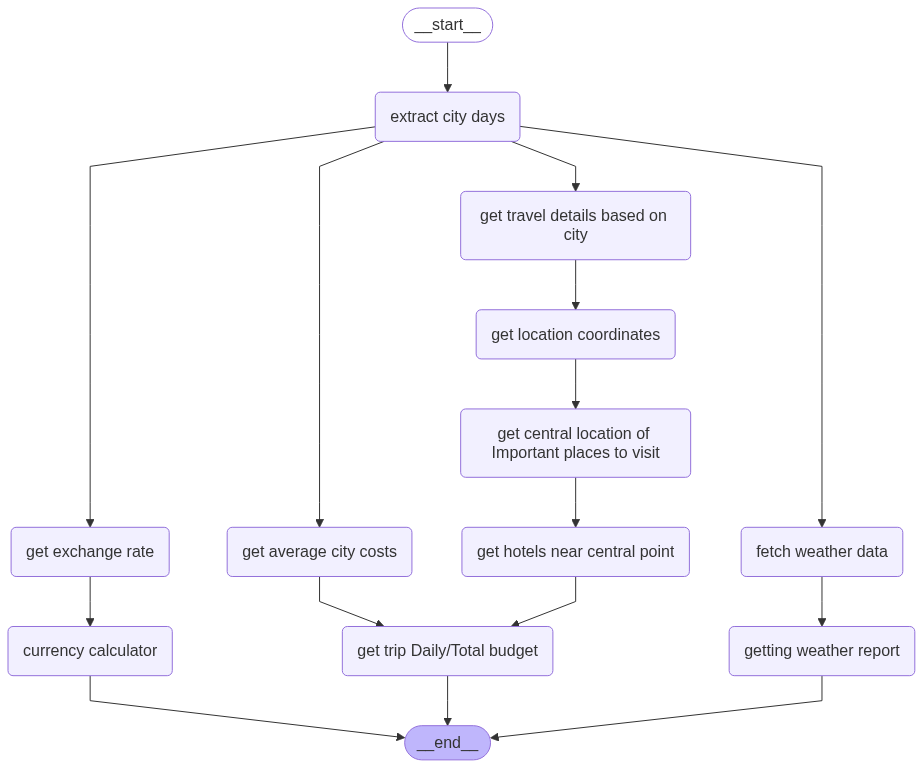

In [47]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [48]:
initial_state: TravelState = {
    "questions": ["I want to visit Tokyo for 1 week?"]
}

result = app.invoke(initial_state)
print(result)


InvalidUpdateError: At key 'city': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

In [ ]:
result

NameError: name 'result' is not defined

In [ ]:
# extract_location_and_days_gpt({
#     "questions": ["I want to visit Tokyo for 1 week?"]
# })

{'questions': ['I want to visit Tokyo for 1 week?'],
 'city': 'Tokyo',
 'days': 7,
 'from_currency': 'INR',
 'to_currency': 'JPY'}

In [ ]:
result.keys()

dict_keys(['questions', 'city', 'days', 'from_currency', 'to_currency', 'attractions', 'restaurants', 'activities', 'transportation', 'current_weather_report', 'weather_forecast_report', 'locations_to_visit', 'attractions_coordinates', 'hotels_at_location_info', 'hotel_per_night', 'food_per_day', 'transport_per_day', 'attraction_per_day', 'daily_budget', 'total_budget', 'exchange_rate', 'converted_amount', 'itinerary'])

In [ ]:
keyList = ['questions', 'attractions', 'restaurants', 'activities', 'transportation', 'current_weather_report', 'weather_forecast_report', 'locations_to_visit', 'hotels_at_location_info', 'hotel_per_night', 'food_per_day', 'transport_per_day', 'attraction_per_day', 'daily_budget', 'total_budget', 'exchange_rate', 'converted_amount', 'itinerary']
for key in keyList:
    print(result[key]+"\n")

I want to visit Bangalore for 1 week?

For a well-rounded visit to Bangalore, consider the following attractions:

1. Explore art at the National Gallery of Modern Art and Rangoli Metro Art Center.
2. Revel in nature at Cubbon Park, Lalbagh Botanical Gardens, and Bannerghatta National Park.
3. Visit historical sites like Bangalore Palace, Tipu Sultan’s Summer Palace, and Vidhana Soudha.
4. Enjoy leisure activities at Ulsoor Lake and Wonderla Amusement Park.
5. Discover science and technology at Jawaharlal Nehru Planetarium and Visvesvaraya Industrial and Technological Museum.
6. Shop at MG Road, UB City Mall, and Commercial Street.
7. Experience local cuisine at VV Puram Food Street.
8. Visit religious sites like ISKCON Temple, Bull Temple, Shiva Temple, Infant Jesus Church, and Ranganathaswamy Temple.
9. Enjoy the spectacle at Indira Gandhi Musical Fountain Park.
10. Adventure seekers can visit Male Mahadeshwara Hills.

Also, consider taking a wildlife jeep safari tour at Bannerghatta

TypeError: can only concatenate list (not "str") to list

In [ ]:
# for index, res in enumerate(result):
#     print(result['questions'])

I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?
I want to visit Bangalore for 1 week?


In [ ]:
# for index, res in enumerate(result['itinerary']['itinerary']):
#     print(f"Day {index + 1}: {result['itinerary']['itinerary'][res]}")

Day 1: **Day 1 - Exploring the Garden City: Bangalore**

**Morning:**

- Start your day bright and early at 8:00 AM with a hearty breakfast at Vidyarthi Bhavan, known for its iconic dosa and South Indian cuisine. 

- Post breakfast, head to the lush Lalbagh Botanical Gardens (8:30 AM - 10:30 AM) for a morning stroll amidst nature. These gardens are a haven for botany enthusiasts and a great spot for photography.

- Next, make your way to the National Gallery of Modern Art (11:00 AM - 12:30 PM) to immerse yourself in contemporary Indian art. 

**Afternoon:**

- By 1:00 PM, you should be ready for lunch. Head over to Vivanta Whitefield for a luxury dining experience. 

- Post lunch, visit the majestic Bangalore Palace (2:30 PM - 4:00 PM) to marvel at its stunning architecture and learn about the city's royal history.

- From there, move to the Vidhana Soudha (4:30 PM - 5:30 PM), the seat of the state legislature. This imposing building is a symbol of Bangalore's political significance.



In [ ]:
{'questions': ['I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?', 'I want to visit Bangalore for 1 week?'], 'city': 'Bangalore', 'days': 7, 'from_currency': 'INR', 'to_currency': 'USD', 'attractions': "Based on the provided content, here is a structured summary of top 10 tourist attractions in Bangalore:\n\n1. **Bangalore Palace:** A must-visit for its remarkable architecture and historical significance.\n2. **Cubbon Park:** Enjoy the lush greenery and tranquility in the heart of the city.\n3. **MG Road:** Known for shopping and dining experiences.\n4. **Lalbagh:** Renowned botanical garden with a wide variety of flora.\n5. **Bannerghatta National Park:** Offers a wildlife safari experience.\n6. **UB City Mall:** A luxury shopping destination.\n7. **Tipu Sultan's Palace:** A glimpse into the historical legacy of the city.\n8. **Nandi Hills:** Offers beautiful panoramic views of the city.\n9. **Vidhana Soudha:** Remarkable for its Dravidian architecture.\n10. **ISKCON Temple:** A major religious site attracting devotees from around the world.\n\nActivities can include exploring art galleries, gardens, amusement parks, and museums. For shopping, MG Road, UB City Mall, and Commercial Street are recommended.", 'restaurants': 'Top 10 Restaurants in Bengaluru:\n\n1. **Bengaluru Oota Company**: Offers an intimate dining experience with a "by reservation only" system. It features a changing Gowda-Mangalorean menu based on fresh market ingredients.\n\n2. **Le Cirque Signature, The Leela Palace Bengaluru**: A fine-dining restaurant that presents a fusion of French delicacy and Italian piquancy.\n\n3. **Lupa**: Renowned chef Manu Chandra\'s comeback to the restaurant kitchen, offering an innovative culinary experience.\n\n4. **Grasshopper Restaurant**: Known as one of the best restaurants in Bangalore for candlelight dinners.\n\n5. **Truffles Koramangala**: Famous for its delicious burgers and fries.\n\n6. **Treat Restaurant**: Offers a variety of delectable North Indian dishes.\n\n7. **Big Brewsky**: Another good option for tasting North Indian cuisine.\n\n8. **Meghana Foods**: A place where you can try various North Indian dishes.\n\n9. **Amulya Veg Restaurant**: If you prefer vegetarian food, this place offers an array of North Indian dishes.\n\n10. **Time Traveller**: An Indian restaurant with an international touch.\n\nRemember, each of these restaurants offers a unique dining experience that represents a mix of cuisines, cooking techniques, and innovations in fine dining.', 'activities': "1. Slide down the thrilling Snow Slides on mats.\n2. Experience the magic of a Real Snowfall.\n3. Enjoy a snowy dance party at the Snow Dance Floor.\n4. Challenge yourself with Snow Mountain Climbing.\n5. Participate in a friendly Snow Hiking race.\n6. Immerse yourself in a 9D Theatre movie experience.\n7. Explore the museum at Tipu Sultan's fort, showcasing his personal belongings.\n8. Check out the replica of Tipu's Tiger and the durbar hall.\n9. Visit the Zenana quarters at Tipu Sultan's fort.\n10. Experience the thrilling Interstellar Galactica water ride, and remember to bring swimwear, cellphone covers, and caps.", 'transportation': "For public transportation in Bengaluru, you have options like BMTC buses, Namma Metro, NICE Road Services, and Metro Feeder services. Consider using the Moovit public transit app for route planning and ticket prices. For local tips, use apps like Google Maps, BMTC, or Namma Metro to plan your routes, carry change for easy payments, avoid peak hours (8:00-10:00 AM and 5:00-8:00 PM), and use trusted ride-hailing apps at night. \n\nBuses available are Vajra (Volvo AC Buses) for office-goers and long-distance routes, Vayu Vajra (Airport Shuttle) for airport transfer, Regular Non-AC Buses for budget travel, and Special Buses for IT Hubs. For short trips, tourists often use app-based taxi services like Uber. There's also the option of using the Metro train for budget travel and avoiding traffic. \n\nRemember to plan ahead, carry small denominations of cash, avoid peak traffic hours, and prioritize safety, especially during late hours.", 'current_weather_report': '1. Current Weather Summary:\n   In Bangalore, the current temperature is a comfortable 23.2°C, with a breeze flowing at a speed of 8.4 km/h. The weather code indicates partially cloudy conditions.', 'weather_forecast_report': '2. 7-Day Weather Overview:\n   Over the next week, you can expect mild temperatures in Bangalore, with highs ranging from 28.2°C to 29.4°C and lows between 20.1°C and 21.1°C. The wind will be fairly consistent, reaching a maximum speed of up to 18.7 km/h. There is a slight chance of rain, particularly on the 22nd with an expected rainfall of 6.4 mm. However, the rest of the week appears to be mostly dry.', 'locations_to_visit': ['Bangalore Palace', 'Cubbon Park', 'MG Road', 'Lalbagh', 'Bannerghatta National Park', 'UB City Mall', "Tipu Sultan's Palace", 'Nandi Hills', 'Vidhana Soudha', 'ISKCON Temple', 'Commercial Street'], 'attractions_coordinates': [(12.9985954, 77.5920086), (12.9808954, 77.597562), (12.9755264, 77.6067902), (12.9465345, 77.5800377), (12.5329059, 77.5461907), (12.9723336, 77.596114), (13.5221981, 77.6790109), (12.9797454, 77.5906167), (13.011855, 77.5514407), (12.9822423, 77.608265)], 'hotels_at_location_info': {None: "Apologies for the confusion, but the information provided doesn't include specific hotel names, prices, or notable features. To categorize the hotels according to your request, I'd need a list of hotels with their respective prices and features. Please provide the necessary data, and I'll be glad to assist you further.", 'Railway Station': "I'm sorry, but the data provided doesn't include specific hotel names or their prices. Please provide detailed information about the hotels, including their names, prices, and any notable features. Once this information is provided, I'd be more than happy to help categorize the hotels for you.", 'Airport': "I'm sorry but the provided data does not include specific hotel names, their prices or notable features. In order to categorize hotels, I would need specific information about each hotel including its name, price and any special features it may have. \n\nCould you please provide the necessary data so I can assist further?", 'Bus Station': "I'm sorry, but I don't see any specific hotel data or prices in the information provided. Please provide the necessary hotel names, prices, and notable features so I can categorize them accurately.", 'City Center': "I'm sorry but the information you've provided does not include specific hotel names, their prices, or their notable features. In order to categorize the hotels based on price, I would need specific details about each hotel. Could you please provide more detailed information?"}}

{'questions': ['I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?',
  'I want to visit Bangalore for 1 week?'

In [ ]:
{'questions': 'I want to visit Bangalore for 1 week?', 'city': 'Bangalore', 'days': 7, 'from_currency': 'INR', 'to_currency': 'USD', 'attractions': 'For a well-rounded visit to Bangalore, consider the following attractions:\n\n1. Explore art at the National Gallery of Modern Art and Rangoli Metro Art Center.\n2. Revel in nature at Cubbon Park, Lalbagh Botanical Gardens, and Bannerghatta National Park.\n3. Visit historical sites like Bangalore Palace, Tipu Sultan’s Summer Palace, and Vidhana Soudha.\n4. Enjoy leisure activities at Ulsoor Lake and Wonderla Amusement Park.\n5. Discover science and technology at Jawaharlal Nehru Planetarium and Visvesvaraya Industrial and Technological Museum.\n6. Shop at MG Road, UB City Mall, and Commercial Street.\n7. Experience local cuisine at VV Puram Food Street.\n8. Visit religious sites like ISKCON Temple, Bull Temple, Shiva Temple, Infant Jesus Church, and Ranganathaswamy Temple.\n9. Enjoy the spectacle at Indira Gandhi Musical Fountain Park.\n10. Adventure seekers can visit Male Mahadeshwara Hills.\n\nAlso, consider taking a wildlife jeep safari tour at Bannerghatta National Park or a guided tour at Tipu Palace.', 'restaurants': "1. [Vivanta Whitefield](https://www.zomato.com/bangalore/restaurants/in/vivanta-whitefield): A luxury dining experience.\n2. [Taj MG Road](https://www.zomato.com/bangalore/restaurants/in/taj-mg-road): Known for its high-end ambience.\n3. [ITC Gardenia](https://www.zomato.com/bangalore/restaurants/in/itc-gardenia-residency-road): Offers an exquisite dining experience.\n4. [ITC Windsor](https://www.zomato.com/bangalore/restaurants/in/itc-windsor): Renowned for its elegant setting.\n5. [Sheraton Grand Bangalore, Brigade Gateway](https://www.zomato.com/bangalore/restaurants/in/sheraton-grand-bangalore-brigade-gateway): Upscale dining with various cuisine options.\n6. [The Zuri Oberoi](https://www.zomato.com/bangalore/restaurants/in/the-oberoi): Famous for its luxurious dining atmosphere.\n7. [The Taj West End, Race Course Road](https://www.zomato.com/bangalore/restaurants/in/the-taj-west-end-race-course-road): Known for its scenic location and premium dining experience.\n8. [St Marks Hotel, MG Road](https://www.zomato.com/bangalore/restaurants/in/st-marks-hotel-mg-road): Offers an array of gastronomical delights.\n9. [The Capitol, Cunningham Road](https://www.zomato.com/bangalore/restaurants/in/the-capitol-cunningham-road): Noted for its stylish and contemporary dining experience.\n10. [Atria Hotel, Race Course Road](https://www.zomato.com/bangalore/restaurants/in/royal-meenakshi-mall-bannerghatta-road): Offers a wide range of cuisines.\n\nAdditional mentions:\n- Hotel Aditya: Known for Andhra cuisine, only serves non-veg.\n- Hotel Navayuga: Famous for its Andhra cuisine, both veg and non-veg.\n- Vidyarthi Bhavan: Iconic for its dosa and South Indian cuisine.\n- The 13th Floor, Barton Centre: Noted for its view, but limited food and drinks options.\n- Inntense Restobar, Indiranagar: Known for its lively ambience.\n- T'Art Cafe: Noteworthy for its hot chocolate but a bit pricey.\n- Kapoor's Cafe: Highly recommended for North Indian cuisine.", 'activities': "For a memorable visit, engage in various activities such as visiting game and entertainment centers, watching a film in a local movie theater, or trying your hand at pottery in a paint & pottery studio. Test your problem-solving skills with room escape games or partake in competitive fun at sports complexes. Try scavenger hunts or shooting ranges for an adventurous day out, or enjoy a laid-back day at mini golf courses, bowling alleys, and local playgrounds. If you're feeling lucky, visit a casino or witness a romantic moment at wedding chapels. Horse track visits can also be arranged. \n\nYou might also consider attending hip-hop night parties, visiting amusements parks like Wonderla, or exploring quirky cafes. Participate in pottery or painting workshops or rent a bike for a city tour. Food lovers can experience the local food truck culture and vintage shopping can be done in areas like Malleswaram and Jayanagar. \n\nFor tech enthusiasts, consider checking out the local scene in areas like 3D Printing, Artificial Intelligence and Machine Learning, Computers & Hardware, Consumer Electronics, DIY Electronics, Programming, Software & Apps, and various video game genres. \n\nDon't forget to explore local culinary gems like MTR or Vidyarthi Bhavan, stroll through Lalbagh Botanical Gardens, and admire the local architecture around Cubbon.", 'transportation': "Bengaluru offers multiple public transportation options for navigating the city. The main components of the public transportation system include BMTC buses and Namma Metro. The city also has a variety of transit types operated by agencies like Namma Metro (BMRCL), NICE Road Services BMTC (NICE Buses), BMTC, Metro Feeder BMTC (MF Buses), Vajra BMTC (AC Services), and Vayu-Vajra BMTC (Airport AC Services).\n\nFor efficient travel planning, consider using apps like Google Maps, the BMTC app, or the Namma Metro app. Always carry change for easier payments, particularly on buses and autos. To avoid traffic congestion, it's advisable to travel outside of peak hours (8:00–10:00 AM and 5:00–8:00 PM). For safety, consider using trusted ride-hailing apps at night and avoid isolated areas.\n\nFor first-time visitors, the Metro train can be a budget-friendly option and a way to avoid traffic. Many visitors also find app-based taxi services like Uber useful for short trips. Whether using the efficient Namma Metro, taking a ride in an auto-rickshaw, or opting for a shared bike, there's a mode of transport to suit every need in Bengaluru.", 'current_weather_report': "1. Current Weather Summary:\n   Bangalore is currently experiencing a mild temperature of 22.9°C with a slight breeze blowing at 8.8 km/h. The weather code 3 indicates it's partially cloudy.", 'weather_forecast_report': '2. 7-Day Weather Forecast:\n   Over the next week, the weather in Bangalore will be fairly consistent. The maximum temperatures will range from 28.2°C to 29.4°C, while the minimum temperatures will hover between 20.1°C and 21.1°C. The wind speeds will vary, with the highest being 18.7 km/h. Rainfall is expected to be light for the most part, with a significant downpour likely on the 22nd of June.', 'locations_to_visit': ['National Gallery of Modern Art', 'Rangoli Metro Art Center', 'Cubbon Park', 'Lalbagh Botanical Gardens', 'Bannerghatta National Park', 'Bangalore Palace', 'Tipu Sultan’s Summer Palace', 'Vidhana Soudha', 'Ulsoor Lake', 'Wonderla Amusement Park', 'Jawaharlal Nehru Planetarium', 'Visvesvaraya Industrial and Technological Museum', 'MG Road', 'UB City Mall', 'Commercial Street', 'VV Puram Food Street', 'ISKCON Temple', 'Bull Temple', 'Shiva Temple', 'Infant Jesus Church', 'Ranganathaswamy Temple', 'Indira Gandhi Musical Fountain Park', 'Male Mahadeshwara Hills', 'Tipu Palace'], 'attractions_coordinates': [(12.9895185, 77.5881044), (12.9762533, 77.6039616), (12.9808954, 77.597562), (12.9488492, 77.5868882), (12.5329059, 77.5461907), (12.9985954, 77.5920086), (12.9797454, 77.5906167), (12.9823891, 77.6191669), (12.9845478, 77.5898598), (12.9752086, 77.5964207), (12.9755264, 77.6067902), (12.9723336, 77.596114), (12.9822423, 77.608265), (13.011855, 77.5514407), (12.9417567, 77.5687277), (12.9805392, 77.6155421), (12.9535975, 77.6187875), (12.970304, 77.5792557), (12.9853656, 77.5916724), (12.9594841, 77.5755911)], 'hotels_at_location_info': {None: "I'm sorry, but it appears there was an error in retrieving the data related to the hotels. Without the data, I'm unable to provide a list of hotels and categorize them based on price. I recommend trying to access the data again or contact the responsible service for the malfunction.", 'Railway Station': "I'm sorry, but the data you've provided does not include the price for the hotels. I need the price information to categorize the hotels accordingly. Can you please provide the prices for the hotels?", 'Airport': 'Based on the information provided, the hotels can be classified into the following categories:\n\n**Hotels under ₹1000**\n1. Felix Inn - Manyata Tech Park\n2. Fly Inn\n3. Hotel Southgate Villa Near Bangalore Airport\n\n**Hotels under ₹2000**\n1. Hotel Sterling Inn: Offers a comfortable base for travelers. Enjoy authentic local cuisine for breakfast and in-room WiFi.\n2. Attide Hotel\n3. ROYAL ACE LUXUR\n\n**Hotels under ₹3000**\n1. 080 Transit Hotel\n2. Clarks Exotica- Convention Resort & Spa\n3. SM Royal Stay\n4. Hotel Presidency - Bangalore Airport Hotel\n5. Fiestaa Resort-n-Events Venue\n\n**Hotels under ₹4000**\n1. Signature Club Resort\n2. Bloom Hotel - Bengaluru Airport\n3. Regenta Inn, Airport Road Devanahalli\n4. Moxy Bengaluru Airport Prestige Tech Cloud\n5. Hotel Skylights Bangalore Airport\n\n**Hotels under ₹7000**\n1. Taj Bangalore\n2. Veerdency Luxury Resort\n3. Fantasy Golf Resort\n4. Shivas Gateway\n5. Goldfinch Retreat Bangalore\n\n**Luxury Hotels (above ₹7000)**\n1. The Windflower Prakruthi - Bangalore Resort\n2. Airport Regency\n3. Shivas Galaxy Hotel Bangalore\n4. Royal Orchid\n5. Click Hotel Bangalore\n\nPlease note that the prices are not provided for all the hotels, so the classification is based on the assumption that the hotels are listed in ascending order of price.', 'Bus Station': 'Hotels under ₹1000:\n1. FabExpress Kings Suites Banaswadi - Approximate price is under ₹1000. Notable feature is its economical pricing.\n\nHotels under ₹2000:\n1. FabExpress Golden Comforts - Approximate price is under ₹2000. Notable feature is its comfortable accommodations.\n2. FabHotel The BTM Palace - Approximate price is under ₹2000. Notable feature is its prime location.\n\nHotels under ₹3000:\n1. FabHotel Royale Basant Residency - Approximate price is under ₹3000. Notable feature is its luxurious amenities within an affordable price range.\n\nHotels under ₹4000:\n1. Octave Hotel and Spa - JP Nagar - Approximate price is under ₹4000. Notable feature is its proximity to Shivajinagar Bus Station and its spa facilities.\n2. Blue Bliss Hotels By PPH Living Infantry Road - Approximate price is under ₹4000. Notable feature is its central location and proximity to Cubbon Park and M.G. Road.\n\nHotels under ₹7000:\n1. IRIS The Business Hotel and Spa - Approximate price is under ₹7000. Notable feature is its comfortable rooms and spa and its proximity to Kempegowda Bus Station.\n2. The Elanza Hotel - Approximate price is under ₹7000. Notable feature is its luxurious accommodations.\n\nLuxury Hotels (above ₹7000):\n1. Holiday Inn Bengaluru Racecourse - Approximate price is above ₹7000. Notable feature is its 5-star rating.\n2. Vividus - Approximate price is above ₹7000. Notable feature is its high customer ratings.', 'City Center': 'Based on the data, I could not find specific price points for the hotels. However, here are the hotels sorted into the general categories:\n\n- Hotels under ₹1000:\n  It\'s unclear which hotels fall into this category from the data provided.\n\n- Hotels under ₹2000:\n  It\'s unclear which hotels fall into this category from the data provided.\n\n- Hotels under ₹3000:\n  Possibly include "Minerva Residency - Hostel", a 1-star hotel with a guest review score of 4 out of 5, located about a 14-minute walk from City Centre Bengaluru.\n\n- Hotels under ₹4000:\n  Possibly include "Arafa Inn", a 3-Star hotel with a guest review score of 4 out of 5, located approximately a 16-minute walk from City Centre Bengaluru.\n\n- Hotels under ₹7000:\n  It\'s unclear which hotels fall into this category from the data provided.\n\n- Luxury Hotels (above ₹7000):\n  Possible options include "The Capitol Hotel", "Hotel Ivory Tower", "juSTa MG Road Hotel", "Hotel TAP Gold Crest", "The Citadel Hotel", "Chancery Pavillion Hotel", "IRIS The Business Hotel and Spa", "The Elanza Hotel", "Hotel Grand Suites", and "KSTDC KumaraKrupa Hotel". These hotels are noted for their excellent service, comfortable rooms, and proximity to major tourist attractions.\n\nPlease note that the prices for each hotel are approximations and should be checked for accuracy through their respective links or websites.'}}
